In [1]:
import pandas as pd
import re
import string
import math
import seaborn as sns
import nltk
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect

from collections import Counter

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


In [3]:
hp = pd.read_csv('analysis/headphones_yt_2.csv')
hp.drop(['Title', 'Description', 'Channel'], axis='columns', inplace=True)
hp.rename(columns = {'Comment': 'text'}, inplace = True)
hp.text = hp.text.apply(str)


In [4]:
hp.shape


(1368, 1)

### Detect only english comments

In [5]:
def detect_en(text):
    """Function to detect just english text
    """
    try:
        return detect(text) == 'en'
    except:
        return False

### Open contractions, example: "don't": "do not":

In [6]:
# Dictionary of English Contractions
contractions_dict = { 
                     "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not", "couldn`t": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have", "Ive": "I have", "Im": "I am", "i'd": "I do", 
                     "thats": "that is", "i'm": "I am", "You‘re": "you are", "That’s": "that is", "I’m": "I am", "/": " "}

# Function for expanding contractions
def expand_contractions(self, contractions_dict=contractions_dict):
    """Function to replace contractions to the open format
    """
# Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, self)

### Replace abbreviations for the real form

In [7]:
## chat words
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    """Function to replace abbreviations to the whole form
    """
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

### Transform entire text to lowercase 

In [8]:
def lower_text(self):
    """ Function to lowercase the text
    """
    return self.lower()

### Remove stopwords and other words

In [9]:
def remove_stopwords(self):
    """Function to remove the stopwords"""

    stop_words = set(nltk.corpus.stopwords.words('english'))
    #não remover palavras importantes
    exclude_words = set(("and", "or", "no"))
    new_stop_words = stop_words.difference(exclude_words)
    return " ".join([word.lower() for word in str(self).split() if word not in new_stop_words])

### Remove symbols and special characters

In [10]:
def remove_symbols(text):   
    
    #remover @username 
    text = re.sub(r'@([^\s]+)', r'', text)
    
    #remover pontuação
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    
    #remover www.* or https?://* 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ', text)
   
  
    #substituir #word para word(remover hashtag)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    
    #remover parentes e conteudo dos parentesis 
    "usar ou não????"
    text = re.sub(r'\([^)]*\)', '', text)
    
    #remover todos os outros caracteres (exceto numeros e letras)
    text = re.sub(r"[^\w\s]", '', text)
    
    #substituir traço por espaço:
    text = re.sub(r"([A-z])\-([A-z])", r"\1 \2", text)

    #trim
    text = text.strip('\'"')
    
    #remover letras em excesso, como happyyyyyyyy fica happyy:
    "precisa usar?"
    rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    text = rpt_regex.sub(r"\1\1", text)
    
    #codigo dos emojis:
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    #remover emojis do texto, no futuro podemos substiuir por palavras:
    def emoji(text):
        text = emoji_pattern.sub(r'', text)
        return text
    
    #remover emoticons:
    emoticons = \
    [
     ('__positive__',[ ':-)', ':)', '(:', '(-:', \
                       ':-D', ':D', 'X-D', 'XD', 'xD', \
                       '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
     ('__negative__', [':-(', ':(', '(:', '(-:', ':,(',\
                       ':\'(', ':"(', ':((', ] ),\
    ]
    
    def replace_parenth(arr):
        return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]
    
    def regex_join(arr):
        return '(' + '|'.join( arr ) + ')'

    emoticons_regex = [ (repl, re.compile(regex_join(replace_parenth(regx))) ) \
            for (repl, regx) in emoticons ]
    
    for (repl, regx) in emoticons_regex :
        text = re.sub(regx, ' '+repl+' ', text)
    
    return text

### Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens:

In [11]:
def tokenizer(text):
    word_list = nltk.word_tokenize(text)
    return word_list


#### Lemmatization: takes the word to its root form, called Lemma. This helps to bring the words into their dictionary form. It is applied to nouns by default. It's more accurate because it uses more informed analysis to create groups of words with similar meanings based on context, so it's complex and takes more time. This is used where we need to retain contextual information.
#### Stemming: A technique that takes the word to its root form. It just removes the suffixes from the words. The radical word may not be in the dictionary, that is, it will not necessarily have a meaning. There are two main types of stemmer - Porter Stemmer and Snow Ball Stemmer (advanced version of Porter Stemmer).
## In this case, lemmatization is a more suitable operation, as it takes into account the morphological analysis of the word.

In [12]:
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    sentence_words = tokenizer(text)
    for word in sentence_words:
        sentence_words.remove(word)
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])    


### Apply all the functions above to clean the text data

In [13]:
def cleaning_process(df):
    
    df['english'] = df['text'].apply(detect_en)
    df['no_contractions'] = df['text'].apply(expand_contractions) 
    df['no_chat'] = df['no_contractions'].apply(chat_words_conversion)
    df['lower_text'] = df['no_chat'].apply(lower_text)   
    df['no_stop'] = df['lower_text'].apply(remove_stopwords)
    df['no_symbols'] = df['no_stop'].apply(remove_symbols) 
    df['lemma'] = df['no_symbols'].apply(lemmatize_words)
    df['token'] = df['lemma'].apply(tokenizer)



    df = df.drop(['no_contractions', 'no_chat', 'lower_text', 'no_stop', 'no_symbols'], axis='columns', inplace=True)
    return df  
    


In [14]:
cleaning_process(hp)


In [15]:
hp.head(5)

,text,english,lemma,token
0,"I am also a big fan of Beyerdynamic, I LOVE my...",True,also big fan beyerdynamic love dt880s pro make...,"[also, big, fan, beyerdynamic, love, dt880s, p..."
1,The 880s are a very unique and special headpho...,True,880s unique and special headphone take time ge...,"[880s, unique, and, special, headphone, take, ..."
2,2 pros chatting 😅,True,2 pro chat,"[2, pro, chat]"
3,@In The Mix Im considering buying the DT770...,True,mix consider buy dt770 produce go thanks mention,"[mix, consider, buy, dt770, produce, go, thank..."
4,@In The Mix I use 770s for DJing since I nee...,True,mix use 770s djing since need isolation and 99...,"[mix, use, 770s, djing, since, need, isolation..."


### Remove empty cells, short sentences or non-english lines

In [16]:
def no_english_drop(df):    
    df = df.drop(df[df['english'] == False ].index, inplace=True)
    return df
no_english_drop(hp)

In [17]:
hp

,text,english,lemma,token
0,"I am also a big fan of Beyerdynamic, I LOVE my...",True,also big fan beyerdynamic love dt880s pro make...,"[also, big, fan, beyerdynamic, love, dt880s, p..."
1,The 880s are a very unique and special headpho...,True,880s unique and special headphone take time ge...,"[880s, unique, and, special, headphone, take, ..."
2,2 pros chatting 😅,True,2 pro chat,"[2, pro, chat]"
3,@In The Mix Im considering buying the DT770...,True,mix consider buy dt770 produce go thanks mention,"[mix, consider, buy, dt770, produce, go, thank..."
4,@In The Mix I use 770s for DJing since I nee...,True,mix use 770s djing since need isolation and 99...,"[mix, use, 770s, djing, since, need, isolation..."
...,...,...,...,...
1362,buy a cheap headphones. slap on sonarworks and...,True,buy cheap headphone slap sonarworks and make b...,"[buy, cheap, headphone, slap, sonarworks, and,..."
1363,I purchased m40x yesterday and wasn't satisfie...,True,purchase m40x yesterday and satisfied bass lik...,"[purchase, m40x, yesterday, and, satisfied, ba..."
1364,Compared to the beats headphones which blast b...,True,compare beat headphone blast bass m40x flat so...,"[compare, beat, headphone, blast, bass, m40x, ..."
1365,"Hey, is Audio-Technica ATH-M50X really worth ...",True,hey audiotechnica athm50x really worth buy rea...,"[hey, audiotechnica, athm50x, really, worth, b..."


In [18]:
def remove_small_sentence(df):
    """Function to remove sentences smaller than 3 words
    """
    wantedRows = df[df['lemma'].str.split().str.len()<=3].index 
    df =  df.drop(wantedRows, axis = 0, inplace=True)       
    return df
remove_small_sentence(hp)

In [19]:
hp

,text,english,lemma,token
0,"I am also a big fan of Beyerdynamic, I LOVE my...",True,also big fan beyerdynamic love dt880s pro make...,"[also, big, fan, beyerdynamic, love, dt880s, p..."
1,The 880s are a very unique and special headpho...,True,880s unique and special headphone take time ge...,"[880s, unique, and, special, headphone, take, ..."
3,@In The Mix Im considering buying the DT770...,True,mix consider buy dt770 produce go thanks mention,"[mix, consider, buy, dt770, produce, go, thank..."
4,@In The Mix I use 770s for DJing since I nee...,True,mix use 770s djing since need isolation and 99...,"[mix, use, 770s, djing, since, need, isolation..."
5,Producer collab? Maybe? No? Ok...😂😂,True,producer collab maybe no ok,"[producer, collab, maybe, no, ok]"
...,...,...,...,...
1361,The wrong title for sure because what is best ...,True,wrong title sure best production and mixing al...,"[wrong, title, sure, best, production, and, mi..."
1362,buy a cheap headphones. slap on sonarworks and...,True,buy cheap headphone slap sonarworks and make b...,"[buy, cheap, headphone, slap, sonarworks, and,..."
1363,I purchased m40x yesterday and wasn't satisfie...,True,purchase m40x yesterday and satisfied bass lik...,"[purchase, m40x, yesterday, and, satisfied, ba..."
1364,Compared to the beats headphones which blast b...,True,compare beat headphone blast bass m40x flat so...,"[compare, beat, headphone, blast, bass, m40x, ..."


In [20]:
hp.reset_index(drop=True)


,text,english,lemma,token
0,"I am also a big fan of Beyerdynamic, I LOVE my...",True,also big fan beyerdynamic love dt880s pro make...,"[also, big, fan, beyerdynamic, love, dt880s, p..."
1,The 880s are a very unique and special headpho...,True,880s unique and special headphone take time ge...,"[880s, unique, and, special, headphone, take, ..."
2,@In The Mix Im considering buying the DT770...,True,mix consider buy dt770 produce go thanks mention,"[mix, consider, buy, dt770, produce, go, thank..."
3,@In The Mix I use 770s for DJing since I nee...,True,mix use 770s djing since need isolation and 99...,"[mix, use, 770s, djing, since, need, isolation..."
4,Producer collab? Maybe? No? Ok...😂😂,True,producer collab maybe no ok,"[producer, collab, maybe, no, ok]"
...,...,...,...,...
1127,The wrong title for sure because what is best ...,True,wrong title sure best production and mixing al...,"[wrong, title, sure, best, production, and, mi..."
1128,buy a cheap headphones. slap on sonarworks and...,True,buy cheap headphone slap sonarworks and make b...,"[buy, cheap, headphone, slap, sonarworks, and,..."
1129,I purchased m40x yesterday and wasn't satisfie...,True,purchase m40x yesterday and satisfied bass lik...,"[purchase, m40x, yesterday, and, satisfied, ba..."
1130,Compared to the beats headphones which blast b...,True,compare beat headphone blast bass m40x flat so...,"[compare, beat, headphone, blast, bass, m40x, ..."


## Identify the most frequent words

In [21]:
# spaCy is a library for advanced Natural Language Processing
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

### spacy library used to identify organizations and products that appear the most

In [22]:
def named_entity_barchart(text):    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    return counter.most_common()   
    
print('RAW:', *named_entity_barchart(hp.text), sep='\n')
print('LEMMA:', *named_entity_barchart(hp.lemma), sep='\n')


RAW:
('ORG', 373)
('CARDINAL', 362)
('PERSON', 236)
('DATE', 206)
('PRODUCT', 205)
('GPE', 85)
('MONEY', 67)
('ORDINAL', 60)
('NORP', 58)
('WORK_OF_ART', 35)
('TIME', 25)
('PERCENT', 12)
('FAC', 12)
('LOC', 7)
('QUANTITY', 7)
('LAW', 3)
LEMMA:
('CARDINAL', 617)
('DATE', 172)
('PERSON', 127)
('ORG', 118)
('ORDINAL', 58)
('GPE', 41)
('PRODUCT', 27)
('NORP', 27)
('TIME', 20)
('MONEY', 9)
('QUANTITY', 8)
('FAC', 3)
('WORK_OF_ART', 3)
('LOC', 3)
('EVENT', 1)


In [23]:
#check the cardinal data
def most_common_named_entity_barchart(text, entity=""):
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    return counter.most_common(30)    

In [24]:
print('PRODUCT IN RAW TEXT:', *most_common_named_entity_barchart(hp.text, entity="PRODUCT"), sep='\n')

print('CARDINAL:', *most_common_named_entity_barchart(hp.lemma, entity="CARDINAL"), sep='\n')


PRODUCT IN RAW TEXT:
('M40x', 26)
('DT770', 17)
('M50x', 17)
('M30x', 12)
('K240', 11)
('K702', 8)
('DT 770', 8)
('M20x', 6)
('DT 990', 5)
('HD280', 4)
('MDR 7506', 4)
('M40X', 4)
('HD600', 3)
("DT 770's", 3)
('770', 3)
('DT 240', 3)
('770s', 3)
('880s', 2)
('👌', 2)
('M50', 2)
('M50s', 2)
('DT 770s', 2)
('MDR', 2)
('qc35', 2)
('HD300', 1)
('K90s', 1)
('104s', 1)
('K501', 1)
('the Philips SHP9500', 1)
('the DT990 Pro', 1)
CARDINAL:
('770', 104)
('one', 64)
('990', 33)
('250', 32)
('80', 31)
('k702', 17)
('2', 15)
('two', 14)
('240', 12)
('100', 12)
('50', 11)
('280', 9)
('3', 8)
('10', 8)
('32', 7)
('30', 7)
('60', 6)
('1', 6)
('80ohm', 6)
('5', 5)
('7506', 5)
('40', 5)
('200', 5)
('4', 5)
('20', 5)
('990s', 4)
('702', 4)
('600', 3)
('three', 3)
('32ohm', 3)


/home/huds/git_projects/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


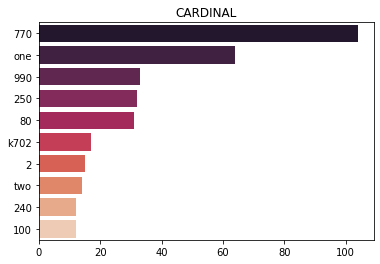

In [39]:
def plot_most_common_named_entity_barchart(text, entity=""):
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(y,x,palette="rocket").set_title(entity)

plot_most_common_named_entity_barchart(hp.lemma, entity="CARDINAL")

## CARDINAL is the entity that appears the most, as we know what our data is about, we can detect that these numbers are, in fact, names (description) of products.

In [40]:
#the cardinals are part of product names but misspelled,
#so let's correct the names and check the above functions again!

#Dictionary for product names
correct_name = { 
                "dt": " ", "audeze": "Audeze", 
                "a7x": "A7X", "dt250": "DT250",   
                "oneodio": "OneOdio", "apple": "Apple",
                "the dt770 pro": "DT770 Pro", "770pro": "DT770 Pro",
                "dt770s": "DT770", "770s": "DT770", "770": "DT770", 
                "dt880s pro": "DT880 Pro", "dt880s": "DT880", "880s": "DT880",
                "880 pro": "DT800 Pro", "880": "DT880",
                "dt990": "DT990", "990s": "DT990", "990": "DT990",
                "xm3": "XM3", "m40x": "M40x", "m50x": "M50x",
                "m30x": "M30x", "m20x": "M20x", "mx400": "MX400", "m50s": "M50s",
                "702s": "k702", "hd600": "HD600",
                "hd 600": "HD600", "k90s": "K90s", "k501":"K501", "k518": "k518",
                "mdr 7506": "MDR7506", "7506": "MDR7506", "k702": "K702", "k240": "K240",
                "sennheiser": "Sennheiser", "sony": "Sony", "audio technica": "ATH",
                "Audio-Technica": "ATH", "audiotechnica": "ATH",
                "beyerdynamic": "Beyer", "beyers": "Beyer", "beyer": "Beyer", "beyers": "Beyer",
                "akg ": "AKG ", "akg": "AKG ", "amazon": "Amazon", "bose": "Bose", "ATH-M50X": "ATH M50x",
                "ath ": "ATH", "ath": "ATH ", "ath m40x": "ATH M40x", "athm40x": "ATH M40x",  "hd 280s": "HD 280", "hd280": "HD 280",
                "jbl": "JBL", "samsung": "Samsung", "samson": "Samson", "sm50": "SM50", "claw": "Claw", "sr850": "SR850"}





#substitute wrong words for the correct ones.
def other_cleaning(df):
    """Functions to replace wrong writings with correct
    """
    def correct_product(self, correct_name=correct_name):
        # Regular expression for finding product_name
        correct_re=re.compile('(%s)' % '|'.join(correct_name.keys()))
        def replace(match):
            return correct_name[match.group(0)]
        return correct_re.sub(replace, self)
    df['remove_symbols'] = df['text'].apply(remove_symbols)
    df['text_products'] = df['remove_symbols'].apply(correct_product)
    df['lemma_w_product'] = df['lemma'].apply(correct_product)   
    df = df.drop(['remove_symbols'], axis='columns', inplace=True)
    return df
    
other_cleaning(hp)

In [41]:
hp.head()

,text,english,lemma,token,text_products,lemma_w_product
0,"I am also a big fan of Beyerdynamic, I LOVE my...",True,also big fan beyerdynamic love dt880s pro make...,"[also, big, fan, beyerdynamic, love, dt880s, p...",I am also a big fan of Beyerdynamic I LOVE my ...,also big fan Beyer love DT880 pro make full p...
1,The 880s are a very unique and special headpho...,True,880s unique and special headphone take time ge...,"[880s, unique, and, special, headphone, take, ...",The DT880 are a very unique and special headph...,DT880 unique and special headphone take time g...
3,@In The Mix Im considering buying the DT770...,True,mix consider buy dt770 produce go thanks mention,"[mix, consider, buy, dt770, produce, go, thank...",The Mix Im considering buying the DTDT770 ...,mix consider buy DT770 produce go thanks mention
4,@In The Mix I use 770s for DJing since I nee...,True,mix use 770s djing since need isolation and 99...,"[mix, use, 770s, djing, since, need, isolation...",The Mix I use DT770 for DJing since I need ...,mix use DT770 djing since need isolation and D...
5,Producer collab? Maybe? No? Ok...😂😂,True,producer collab maybe no ok,"[producer, collab, maybe, no, ok]",Producer collab Maybe No Ok,producer collab maybe no ok


### Checking most common products entities before and after cleaning

In [42]:

print('Products in raw data:', *most_common_named_entity_barchart(hp.text, entity="PRODUCT"), sep='\n')
print('Products in not so raw:', *most_common_named_entity_barchart(hp.text_products, entity="PRODUCT"), sep='\n')
print('Products in normalized data:', *most_common_named_entity_barchart(hp.lemma_w_product, entity="PRODUCT"), sep='\n')



Products in raw data:
('M40x', 26)
('DT770', 17)
('M50x', 17)
('M30x', 12)
('K240', 11)
('K702', 8)
('DT 770', 8)
('M20x', 6)
('DT 990', 5)
('HD280', 4)
('MDR 7506', 4)
('M40X', 4)
('HD600', 3)
("DT 770's", 3)
('770', 3)
('DT 240', 3)
('770s', 3)
('880s', 2)
('👌', 2)
('M50', 2)
('M50s', 2)
('DT 770s', 2)
('MDR', 2)
('qc35', 2)
('HD300', 1)
('K90s', 1)
('104s', 1)
('K501', 1)
('the Philips SHP9500', 1)
('the DT990 Pro', 1)
Products in not so raw:
('M40x', 48)
('M50x', 43)
('DT770', 28)
('M30x', 19)
('DT DT770', 13)
('K240', 11)
('M20x', 8)
('DT DT770 PRO', 6)
('M50s', 6)
('K702', 6)
('DT880', 4)
('HD280', 4)
('HD600', 4)
('DT DT990', 3)
('DT 240', 3)
('M40X', 3)
('DT770 80', 2)
('DT DT770 Pro', 2)
('the ProStudiounnamed DT770', 1)
('Headphones Godsent', 1)
('HD300 Anything', 1)
('K90s', 1)
('104s', 1)
('K501', 1)
('280s', 1)
('the Philips SHP9500', 1)
('DT250', 1)
('My M30x', 1)
('M40s', 1)
('DT DT990 Pro', 1)
Products in normalized data:
('M40x', 60)
('M50x', 52)
('DT770', 42)
('M30x',

/home/huds/git_projects/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


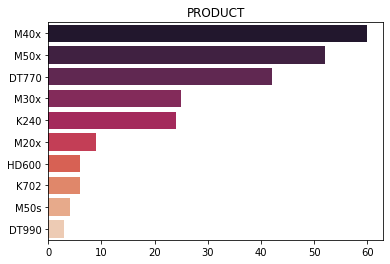

In [43]:
plot_most_common_named_entity_barchart(hp.lemma_w_product, entity="PRODUCT")


### As seen above the quantity of products increased considerably after correction

### Checking most common brands entities before and after cleaning

In [44]:
print('BRAND in raw data:', *most_common_named_entity_barchart(hp.text, entity="ORG"), sep='\n')
print('BRAND in not so raw data:', *most_common_named_entity_barchart(hp.text_products, entity="ORG"), sep='\n')
print('BRAND in normalized data:', *most_common_named_entity_barchart(hp.lemma_w_product, entity="ORG"), sep='\n')


BRAND in raw data:
('Sony', 45)
('Beyerdynamic', 23)
('Amazon', 13)
('Sennheiser', 13)
('ATH', 12)
('DT770', 8)
('MDR', 6)
('M40', 6)
('Beyers', 5)
('🙏', 5)
('k240', 5)
('Samsung', 5)
('DAW', 4)
('OHM', 4)
('LOL', 3)
('sony', 2)
('Audeze', 2)
('👏', 2)
('Apple', 2)
('M40X', 2)
('Monoprice', 2)
('dt990s', 2)
('Kraken', 2)
('♥', 2)
('Skullcandy', 2)
('YouTube', 2)
('amazon', 2)
('AkG', 2)
('DAC', 2)
('Sennheisers', 2)
BRAND in not so raw data:
('Sony', 35)
('ATH', 18)
('Amazon', 17)
('DT770', 16)
('Beyerdynamic', 13)
('Sennheiser', 12)
('MDR7506', 8)
('Beyers', 7)
('Apple', 5)
('Samsung', 5)
('Beyer', 4)
('M40', 4)
('OHM', 4)
('M40X', 3)
('JBL', 3)
('LOL', 3)
('Samson', 3)
('Sonys', 3)
('VModa', 3)
('MDR', 3)
('AudioTechnica', 3)
('Ill', 2)
('K240', 2)
('ATHM40X', 2)
('Beyer  DT770', 2)
('AkG', 2)
('Kraken', 2)
('MDR MDR7506', 2)
('Accurate', 2)
('Skullcandy', 2)
BRAND in normalized data:
('ATH', 51)
('Sony', 35)
('DT770', 29)
('Beyer', 19)
('Amazon', 18)
('Sony MDR7506', 12)
('Beyers', 1

/home/huds/git_projects/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


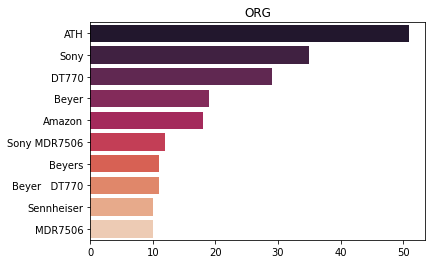

In [61]:
plot_most_common_named_entity_barchart(hp.lemma_w_product, entity="ORG")


### As seen above some brands need better treatment as spacy identifies them along with the product name

In [67]:
import pickle
# pickle save df
Project_path = "analysis"
model_path = Project_path + "/models/"
def save_pkl_pickle(model_path):
    pickle.dump(hp, open(model_path+"hp_data.pickle", 'wb'))
    print ("====done saving into pickle using Pickle!====")
save_pkl_pickle(model_path)


====done saving into pickle using Pickle!====


### This analysis can be useful in the future to identify the consumer sentiment for a choosen product.